In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


#Start
repo - https://github.com/peteryuX/retinaface-tf2

Dataset - http://shuoyang1213.me/WIDERFACE/

Training dataset download link - https://drive.google.com/file/d/15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M/view

Validation dataset download link - https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view

RetinaFace official annotations - http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

In [1]:
import os
import cv2
import json
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd

#Download Dataset and annotations

In [2]:
!mkdir data

In [3]:
#training images
gdd.download_file_from_google_drive(file_id='15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M',
                                    dest_path='/content/data/widertrain.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
#validation images
gdd.download_file_from_google_drive(file_id='1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q',
                                    dest_path='/content/data/widerval.zip',
                                    unzip=True)

Unzipping...Done.


In [5]:
!mkdir labels

In [6]:
#ground truth labels
gdd.download_file_from_google_drive(file_id='1vgCABX1JI3NGBzsHxwBXlmRjaLV3NIsG',
                                    dest_path='/content/labels/widergt.zip',
                                    unzip=True)

Unzipping...Done.


In [7]:
!cp /content/labels/train/label.txt /content/data/WIDER_train/

In [8]:
!cp /content/labels/val/label.txt /content/data/WIDER_val/

## From official site as well http://shuoyang1213.me/WIDERFACE/

In [9]:
!wget http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

--2022-01-10 09:15:59--  http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip
Resolving shuoyang1213.me (shuoyang1213.me)... 192.30.252.153, 192.30.252.154
Connecting to shuoyang1213.me (shuoyang1213.me)|192.30.252.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘wider_face_split.zip’

wider_face_split.zi 100%[===================>]   3.42M  --.-KB/s    in 0.1s    

2022-01-10 09:15:59 (30.6 MB/s) - ‘wider_face_split.zip’ saved [3591642/3591642]



In [ ]:
#!unzip /content/wider_face_split.zip

In [10]:
!cp /content/wider_face_split/wider_face_train_bbx_gt.txt /content/data/WIDER_train
!cp /content/wider_face_split/wider_face_val_bbx_gt.txt /content/data/WIDER_val

cp: cannot stat '/content/wider_face_split/wider_face_train_bbx_gt.txt': No such file or directory
cp: cannot stat '/content/wider_face_split/wider_face_val_bbx_gt.txt': No such file or directory


In [11]:
!mkdir /content/data/widerface
!mkdir /content/data/widerface/train
!mkdir /content/data/widerface/val

# Checking Dataset

In [12]:
train_images_folder = '/content/data/widerface/train/images'
len(os.listdir(train_images_folder))

61

In [13]:
len(os.listdir(os.path.join(
    train_images_folder, 
    os.listdir(train_images_folder)[0])))

105

# Preparing dataset

In [14]:
with open('/content/data/widerface/train/label.txt') as f:
    lines = f.readlines()

In [15]:
lines[:4]

['# 0--Parade/0_Parade_marchingband_1_849.jpg\n',
 '449 330 122 149 488.906 373.643 0.0 542.089 376.442 0.0 515.031 412.83 0.0 485.174 425.893 0.0 538.357 431.491 0.0 0.82\n',
 '# 0--Parade/0_Parade_Parade_0_904.jpg\n',
 '361 98 263 339 424.143 251.656 0.0 547.134 232.571 0.0 494.121 325.875 0.0 453.83 368.286 0.0 561.978 342.839 0.0 0.89\n']

In [16]:
for i,line in enumerate(lines):
    if '#' not in line:
        l = len(line.split())
        if l!=20:
            print(i,l)

# Testing img and bounding boxes

In [ ]:
len(samples)

NameError: ignored

In [ ]:
print(samples[4][0])
for i in samples[4][1]:
    print(i)

NameError: ignored

In [ ]:
im = cv2.imread(samples[4][0])
im.shape

In [ ]:
plt.imshow(im[:,:,::-1])

In [ ]:
samples[4][1][0][:4]

In [ ]:
for s in samples[4][1]:
    x,y,w,h = s[:4]
    cv2.rectangle(im, (int(x), int(y)),(int(x+w), int(y+h)), (0,255,0), 4)

In [ ]:
plt.imshow(im[:,:,::-1])

# Preparing tfrecord

In [17]:
from absl import app, flags, logging

In [18]:
import os
import tqdm
import random
import tensorflow as tf
import numpy as np


dataset_path = './data/widerface/train'
output_path = 'widerface_train_bin.tfrecord'
is_binary = True


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def make_example(img_name, img_path, target, is_binary):
    # Create a dictionary with features that may be relevant.
    feature = {'image/img_name': _bytes_feature([img_name]),
               'image/object/bbox/xmin': _float_feature(target[:, 0]),
               'image/object/bbox/ymin': _float_feature(target[:, 1]),
               'image/object/bbox/xmax': _float_feature(target[:, 2]),
               'image/object/bbox/ymax': _float_feature(target[:, 3]),
               'image/object/landmark0/x': _float_feature(target[:, 4]),
               'image/object/landmark0/y': _float_feature(target[:, 5]),
               'image/object/landmark1/x': _float_feature(target[:, 6]),
               'image/object/landmark1/y': _float_feature(target[:, 7]),
               'image/object/landmark2/x': _float_feature(target[:, 8]),
               'image/object/landmark2/y': _float_feature(target[:, 9]),
               'image/object/landmark3/x': _float_feature(target[:, 10]),
               'image/object/landmark3/y': _float_feature(target[:, 11]),
               'image/object/landmark4/x': _float_feature(target[:, 12]),
               'image/object/landmark4/y': _float_feature(target[:, 13]),
               'image/object/landmark/valid': _float_feature(target[:, 14])}
    if is_binary:
        img_str = open(img_path, 'rb').read()
        feature['image/encoded'] = _bytes_feature([img_str])
    else:
        feature['image/img_path'] = _bytes_feature([img_path])

    return tf.train.Example(features=tf.train.Features(feature=feature))


def load_info(txt_path):
    """load info from txt"""
    img_paths = []
    words = []

    f = open(txt_path, 'r')
    lines = f.readlines()
    isFirst = True
    labels = []
    for line in lines:
        line = line.rstrip()
        if line.startswith('#'):
            if isFirst is True:
                isFirst = False
            else:
                labels_copy = labels.copy()
                words.append(labels_copy)
                labels.clear()
            path = line[2:]
            path = txt_path.replace('label.txt', 'images/') + path
            img_paths.append(path)
        else:
            line = line.split(' ')
            label = [float(x) for x in line]
            labels.append(label)

    words.append(labels)
    return img_paths, words


def get_target(labels):
    annotations = np.zeros((0, 15))
    if len(labels) == 0:
        return annotations
    for idx, label in enumerate(labels):
        annotation = np.zeros((1, 15))
        # bbox
        annotation[0, 0] = label[0]  # x1
        annotation[0, 1] = label[1]  # y1
        annotation[0, 2] = label[0] + label[2]  # x2
        annotation[0, 3] = label[1] + label[3]  # y2

        # landmarks
        annotation[0, 4] = label[4]    # l0_x
        annotation[0, 5] = label[5]    # l0_y
        annotation[0, 6] = label[7]    # l1_x
        annotation[0, 7] = label[8]    # l1_y
        annotation[0, 8] = label[10]   # l2_x
        annotation[0, 9] = label[11]   # l2_y
        annotation[0, 10] = label[13]  # l3_x
        annotation[0, 11] = label[14]  # l3_y
        annotation[0, 12] = label[16]  # l4_x
        annotation[0, 13] = label[17]  # l4_y
        if (annotation[0, 4] < 0):
            annotation[0, 14] = -1  # w/o landmark
        else:
            annotation[0, 14] = 1

        annotations = np.append(annotations, annotation, axis=0)
    target = np.array(annotations)

    return target



if not os.path.isdir(dataset_path):
    logging.info('Please define valid dataset path.')
else:
    logging.info('Loading {}'.format(dataset_path))

logging.info('Reading data list...')
img_paths, words = load_info(os.path.join(dataset_path, 'label.txt'))
samples = list(zip(img_paths, words))
random.shuffle(samples)

if os.path.exists(output_path):
    logging.info('{:s} already exists. Exit...'.format(
        output_path))
    exit()

logging.info('Writing {} sample to tfrecord file...'.format(len(samples)))

with tf.io.TFRecordWriter(output_path) as writer:
    for img_path, word in tqdm.tqdm(samples):
        target = get_target(word)
        img_name = os.path.basename(img_path).replace('.jpg', '')

        tf_example = make_example(img_name=str.encode(img_name),
                                    img_path=str.encode(img_path),
                                    target=target,
                                    is_binary=is_binary)

        writer.write(tf_example.SerializeToString())




100%|██████████| 12880/12880 [00:14<00:00, 861.49it/s]


#Dataset checker

# Configuration

In [19]:
cfg = {
'batch_size': 1,
'input_size': 640,
'backbone_type': 'MobileNetV2',  # 'ResNet50', 'MobileNetV2'
'sub_name': 'retinaface_mbv2',

# training dataset
'dataset_path': '/content/widerface_train_bin.tfrecord',
'dataset_len': 12880,  # number of training samples
'using_bin': True,            #using binary or not
'using_flip': True,
'using_distort': True,

# testing dataset
'testing_dataset_path': './data/widerface/val',

# network
'out_channel': 64,

# anchor setting
'min_sizes': [[16, 32], [64, 128], [256, 512]],
'steps': [8, 16, 32],
'match_thresh': 0.45,
'ignore_thresh': 0.3,
'variances': [0.1, 0.2],
'clip': False,

# training setting
'epoch': 1,
'init_lr': float(1e-2),
'lr_decay_epoch': [50, 68],
'lr_rate': 0.1,
'warmup_epoch': 5,
'min_lr': float(1e-3),

'weights_decay': float(5e-4),
'momentum': 0.9,

'pretrain': True,

'save_steps': 1000
}

# Functions/Utilities - modules

## Anchor

In [20]:
import math
import tensorflow as tf
import numpy as np
from itertools import product as product


###############################################################################
#   Tensorflow / Numpy Priors                                                 #
###############################################################################
def prior_box(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps]

    anchors = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                anchors += [cx, cy, s_kx, s_ky]

    output = np.asarray(anchors).reshape([-1, 4])

    if clip:
        output = np.clip(output, 0, 1)

    return output


def prior_box_tf(image_sizes, min_sizes, steps, clip=False):
    """prior box"""
    image_sizes = tf.cast(tf.convert_to_tensor(image_sizes), tf.float32)
    feature_maps = tf.math.ceil(
        tf.reshape(image_sizes, [1, 2]) /
        tf.reshape(tf.cast(steps, tf.float32), [-1, 1]))

    anchors = []
    for k in range(len(min_sizes)):
        grid_x, grid_y = _meshgrid_tf(tf.range(feature_maps[k][1]),
                                      tf.range(feature_maps[k][0]))
        cx = (grid_x + 0.5) * steps[k] / image_sizes[1]
        cy = (grid_y + 0.5) * steps[k] / image_sizes[0]
        cxcy = tf.stack([cx, cy], axis=-1)
        cxcy = tf.reshape(cxcy, [-1, 2])
        cxcy = tf.repeat(cxcy, repeats=tf.shape(min_sizes[k])[0], axis=0)

        sx = min_sizes[k] / image_sizes[1]
        sy = min_sizes[k] / image_sizes[0]
        sxsy = tf.stack([sx, sy], 1)
        sxsy = tf.repeat(sxsy[tf.newaxis],
                         repeats=tf.shape(grid_x)[0] * tf.shape(grid_x)[1],
                         axis=0)
        sxsy = tf.reshape(sxsy, [-1, 2])

        anchors.append(tf.concat([cxcy, sxsy], 1))

    output = tf.concat(anchors, axis=0)

    if clip:
        output = tf.clip_by_value(output, 0, 1)

    return output


def _meshgrid_tf(x, y):
    """ workaround solution of the tf.meshgrid() issue:
        https://github.com/tensorflow/tensorflow/issues/34470"""
    grid_shape = [tf.shape(y)[0], tf.shape(x)[0]]
    grid_x = tf.broadcast_to(tf.reshape(x, [1, -1]), grid_shape)
    grid_y = tf.broadcast_to(tf.reshape(y, [-1, 1]), grid_shape)
    return grid_x, grid_y


###############################################################################
#   Tensorflow Encoding                                                       #
###############################################################################
def encode_tf(labels, priors, match_thresh, ignore_thresh,
              variances=[0.1, 0.2]):
    """tensorflow encoding"""
    assert ignore_thresh <= match_thresh
    priors = tf.cast(priors, tf.float32)
    bbox = labels[:, :4]
    landm = labels[:, 4:-1]
    landm_valid = labels[:, -1]  # 1: with landm, 0: w/o landm.

    # jaccard index
    overlaps = _jaccard(bbox, _point_form(priors))

    # (Bipartite Matching)
    # [num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = tf.math.top_k(overlaps, k=1)
    best_prior_overlap = best_prior_overlap[:, 0]
    best_prior_idx = best_prior_idx[:, 0]

    # [num_priors] best ground truth for each prior
    overlaps_t = tf.transpose(overlaps)
    best_truth_overlap, best_truth_idx = tf.math.top_k(overlaps_t, k=1)
    best_truth_overlap = best_truth_overlap[:, 0]
    best_truth_idx = best_truth_idx[:, 0]

    # ensure best prior
    def _loop_body(i, bt_idx, bt_overlap):
        bp_mask = tf.one_hot(best_prior_idx[i], tf.shape(bt_idx)[0])
        bp_mask_int = tf.cast(bp_mask, tf.int32)
        new_bt_idx = bt_idx * (1 - bp_mask_int) + bp_mask_int * i
        bp_mask_float = tf.cast(bp_mask, tf.float32)
        new_bt_overlap = bt_overlap * (1 - bp_mask_float) + bp_mask_float * 2
        return tf.cond(best_prior_overlap[i] > match_thresh,
                       lambda: (i + 1, new_bt_idx, new_bt_overlap),
                       lambda: (i + 1, bt_idx, bt_overlap))
    _, best_truth_idx, best_truth_overlap = tf.while_loop(
        lambda i, bt_idx, bt_overlap: tf.less(i, tf.shape(best_prior_idx)[0]),
        _loop_body, [tf.constant(0), best_truth_idx, best_truth_overlap])

    matches_bbox = tf.gather(bbox, best_truth_idx)  # [num_priors, 4]
    matches_landm = tf.gather(landm, best_truth_idx)  # [num_priors, 10]
    matches_landm_v = tf.gather(landm_valid, best_truth_idx)  # [num_priors]

    loc_t = _encode_bbox(matches_bbox, priors, variances)
    landm_t = _encode_landm(matches_landm, priors, variances)
    landm_valid_t = tf.cast(matches_landm_v > 0, tf.float32)
    conf_t = tf.cast(best_truth_overlap > match_thresh, tf.float32)
    conf_t = tf.where(
        tf.logical_and(best_truth_overlap < match_thresh,
                       best_truth_overlap > ignore_thresh),
        tf.ones_like(conf_t) * -1, conf_t)    # 1: pos, 0: neg, -1: ignore

    return tf.concat([loc_t, landm_t, landm_valid_t[..., tf.newaxis],
                      conf_t[..., tf.newaxis]], axis=1)


def _encode_bbox(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return tf.concat([g_cxcy, g_wh], 1)  # [num_priors,4]


def _encode_landm(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth
    boxes we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 10].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded landm (tensor), Shape: [num_priors, 10]
    """

    # dist b/t match center and prior's center
    matched = tf.reshape(matched, [tf.shape(matched)[0], 5, 2])
    priors = tf.broadcast_to(
        tf.expand_dims(priors, 1), [tf.shape(matched)[0], 5, 4])
    g_cxcy = matched[:, :, :2] - priors[:, :, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, :, 2:])
    # g_cxcy /= priors[:, :, 2:]
    g_cxcy = tf.reshape(g_cxcy, [tf.shape(g_cxcy)[0], -1])
    # return target for smooth_l1_loss
    return g_cxcy


def _point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return tf.concat((boxes[:, :2] - boxes[:, 2:] / 2,
                      boxes[:, :2] + boxes[:, 2:] / 2), axis=1)


def _intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2]:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.maximum((max_xy - min_xy), tf.zeros_like(max_xy - min_xy))
    return inter[:, :, 0] * inter[:, :, 1]


def _jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


###############################################################################
#   Tensorflow Decoding                                                       #
###############################################################################
def decode_tf(labels, priors, variances=[0.1, 0.2]):
    """tensorflow decoding"""
    bbox = _decode_bbox(labels[:, :4], priors, variances)
    landm = _decode_landm(labels[:, 4:14], priors, variances)
    landm_valid = labels[:, 14][:, tf.newaxis]
    conf = labels[:, 15][:, tf.newaxis]

    return tf.concat([bbox, landm, landm_valid, conf], axis=1)


def _decode_bbox(pre, priors, variances=[0.1, 0.2]):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """
    centers = priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:]
    sides = priors[:, 2:] * tf.math.exp(pre[:, 2:] * variances[1])

    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)


def _decode_landm(pre, priors, variances=[0.1, 0.2]):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = tf.concat(
        [priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
         priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:]], axis=1)
    return landms

## Datasets

In [21]:

def _parse_tfrecord(img_dim, using_bin, using_flip, using_distort,
                    using_encoding, priors, match_thresh, ignore_thresh,
                    variances):
    def parse_tfrecord(tfrecord):
        features = {
            'image/img_name': tf.io.FixedLenFeature([], tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark0/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark0/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark1/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark1/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark2/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark2/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark3/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark3/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark4/x': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark4/y': tf.io.VarLenFeature(tf.float32),
            'image/object/landmark/valid': tf.io.VarLenFeature(tf.float32)}
        if using_bin:
            features['image/encoded'] = tf.io.FixedLenFeature([], tf.string)
            x = tf.io.parse_single_example(tfrecord, features)
            img = tf.image.decode_jpeg(x['image/encoded'], channels=3)
        else:
            features['image/img_path'] = tf.io.FixedLenFeature([], tf.string)
            x = tf.io.parse_single_example(tfrecord, features)
            image_encoded = tf.io.read_file(x['image/img_path'])
            img = tf.image.decode_jpeg(image_encoded, channels=3)

        labels = tf.stack(
            [tf.sparse.to_dense(x['image/object/bbox/xmin']),
             tf.sparse.to_dense(x['image/object/bbox/ymin']),
             tf.sparse.to_dense(x['image/object/bbox/xmax']),
             tf.sparse.to_dense(x['image/object/bbox/ymax']),
             tf.sparse.to_dense(x['image/object/landmark0/x']),
             tf.sparse.to_dense(x['image/object/landmark0/y']),
             tf.sparse.to_dense(x['image/object/landmark1/x']),
             tf.sparse.to_dense(x['image/object/landmark1/y']),
             tf.sparse.to_dense(x['image/object/landmark2/x']),
             tf.sparse.to_dense(x['image/object/landmark2/y']),
             tf.sparse.to_dense(x['image/object/landmark3/x']),
             tf.sparse.to_dense(x['image/object/landmark3/y']),
             tf.sparse.to_dense(x['image/object/landmark4/x']),
             tf.sparse.to_dense(x['image/object/landmark4/y']),
             tf.sparse.to_dense(x['image/object/landmark/valid'])], axis=1)

        img, labels = _transform_data(
            img_dim, using_flip, using_distort, using_encoding, priors,
            match_thresh, ignore_thresh, variances)(img, labels)

        return img, labels
    return parse_tfrecord


def _transform_data(img_dim, using_flip, using_distort, using_encoding, priors,
                    match_thresh, ignore_thresh, variances):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)

        # randomly crop
        img, labels = _crop(img, labels)

        # padding to square
        img = _pad_to_square(img)

        # resize
        img, labels = _resize(img, labels, img_dim)

        # randomly left-right flip
        if using_flip:
            img, labels = _flip(img, labels)

        # distort
        if using_distort:
            img = _distort(img)

        # encode labels to feature targets
        if using_encoding:
            labels = encode_tf(labels=labels, priors=priors,
                               match_thresh=match_thresh,
                               ignore_thresh=ignore_thresh,
                               variances=variances)

        return img, labels
    return transform_data


def load_tfrecord_dataset(tfrecord_name, batch_size, img_dim,
                          using_bin=True, using_flip=True, using_distort=True,
                          using_encoding=True, priors=None, match_thresh=0.45,
                          ignore_thresh=0.3, variances=[0.1, 0.2],
                          shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    if not using_encoding:
        assert batch_size == 1  # dynamic data len when using_encoding
    else:
        assert priors is not None

    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(
        _parse_tfrecord(img_dim, using_bin, using_flip, using_distort,
                        using_encoding, priors, match_thresh, ignore_thresh,
                        variances),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(
        buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


###############################################################################
#   Data Augmentation                                                         #
###############################################################################
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                1 - labels[:, 6],  labels[:, 7],
                                1 - labels[:, 4],  labels[:, 5],
                                1 - labels[:, 8],  labels[:, 9],
                                1 - labels[:, 12], labels[:, 13],
                                1 - labels[:, 10], labels[:, 11],
                                labels[:, 14]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],
                          default=lambda: (img, labels))

    return img, labels


def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        """
        return iof of a and b, numpy version for data augenmentation
        """
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4] - w_offset,  labels_t[:, 5] - h_offset,
             labels_t[:, 6] - w_offset,  labels_t[:, 7] - h_offset,
             labels_t[:, 8] - w_offset,  labels_t[:, 9] - h_offset,
             labels_t[:, 10] - w_offset, labels_t[:, 11] - h_offset,
             labels_t[:, 12] - w_offset, labels_t[:, 13] - h_offset,
             labels_t[:, 14]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 15])])

    return img, labels


def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * \
            tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)

    return img


def _resize(img, labels, img_dim):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f,
                     labels[:, 4] / w_f,  labels[:, 5] / h_f,
                     labels[:, 6] / w_f,  labels[:, 7] / h_f,
                     labels[:, 8] / w_f,  labels[:, 9] / h_f,
                     labels[:, 10] / w_f, labels[:, 11] / h_f,
                     labels[:, 12] / w_f, labels[:, 13] / h_f], axis=1)
    locs = tf.clip_by_value(locs, 0, 1)
    labels = tf.concat([locs, labels[:, 14][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            return tf.image.resize(
                img, [img_dim, img_dim], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels


def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

## Utils

In [22]:
import cv2
import yaml
import sys
import time
import numpy as np
import tensorflow as tf
from absl import logging



def load_yaml(load_path):
    """load yaml file"""
    with open(load_path, 'r') as f:
        loaded = yaml.load(f, Loader=yaml.Loader)

    return loaded


def set_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices(
                    'GPU')
                logging.info(
                    "Detect {} Physical GPUs, {} Logical GPUs.".format(
                        len(gpus), len(logical_gpus)))
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            logging.info(e)


def load_dataset(cfg, priors, shuffle=True, buffer_size=10240):
    """load dataset"""
    logging.info("load dataset from {}".format(cfg['dataset_path']))
    dataset = load_tfrecord_dataset(
        tfrecord_name=cfg['dataset_path'],
        batch_size=cfg['batch_size'],
        img_dim=cfg['input_size'],
        using_bin=cfg['using_bin'],
        using_flip=cfg['using_flip'],
        using_distort=cfg['using_distort'],
        using_encoding=True,
        priors=priors,
        match_thresh=cfg['match_thresh'],
        ignore_thresh=cfg['ignore_thresh'],
        variances=cfg['variances'],
        shuffle=shuffle,
        buffer_size=buffer_size)
    return dataset


class ProgressBar(object):
    """A progress bar which can print the progress modified from
       https://github.com/hellock/cvbase/blob/master/cvbase/progress.py"""
    def __init__(self, task_num=0, completed=0, bar_width=25):
        self.task_num = task_num
        max_bar_width = self._get_max_bar_width()
        self.bar_width = (bar_width
                          if bar_width <= max_bar_width else max_bar_width)
        self.completed = completed
        self.first_step = completed
        self.warm_up = False

    def _get_max_bar_width(self):
        if sys.version_info > (3, 3):
            from shutil import get_terminal_size
        else:
            from backports.shutil_get_terminal_size import get_terminal_size
        terminal_width, _ = get_terminal_size()
        max_bar_width = min(int(terminal_width * 0.6), terminal_width - 50)
        if max_bar_width < 10:
            logging.info('terminal width is too small ({}), please consider '
                         'widen the terminal for better progressbar '
                         'visualization'.format(terminal_width))
            max_bar_width = 10
        return max_bar_width

    def reset(self):
        """reset"""
        self.completed = 0
        self.fps = 0

    def update(self, inf_str=''):
        """update"""
        self.completed += 1

        if not self.warm_up:
            self.start_time = time.time() - 1e-1
            self.warm_up = True

        if self.completed > self.task_num:
            self.completed = self.completed % self.task_num
            self.start_time = time.time() - 1 / self.fps
            self.first_step = self.completed - 1
            sys.stdout.write('\n')

        elapsed = time.time() - self.start_time
        self.fps = (self.completed - self.first_step) / elapsed
        percentage = self.completed / float(self.task_num)
        mark_width = int(self.bar_width * percentage)
        bar_chars = '>' * mark_width + ' ' * (self.bar_width - mark_width)
        stdout_str = '\rTraining [{}] {}/{}, {}  {:.1f} step/sec'
        sys.stdout.write(stdout_str.format(
            bar_chars, self.completed, self.task_num, inf_str, self.fps))

        sys.stdout.flush()


###############################################################################
#   Testing                                                                   #
###############################################################################
def pad_input_image(img, max_steps):
    """pad image to suitable shape"""
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params


def recover_pad_output(outputs, pad_params):
    """recover the padded output effect"""
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    recover_xy = np.reshape(outputs[:, :14], [-1, 7, 2]) * \
        [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    outputs[:, :14] = np.reshape(recover_xy, [-1, 14])

    return outputs


###############################################################################
#   Visulization                                                              #
###############################################################################
def draw_bbox_landm(img, ann, img_height, img_width):
    """draw bboxes and landmarks"""
    # bbox
    x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                     int(ann[2] * img_width), int(ann[3] * img_height)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # confidence
    text = "{:.4f}".format(ann[15])
    cv2.putText(img, text, (int(ann[0] * img_width), int(ann[1] * img_height)),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    # landmark
    if ann[14] > 0:
        cv2.circle(img, (int(ann[4] * img_width),
                         int(ann[5] * img_height)), 1, (255, 255, 0), 2)
        cv2.circle(img, (int(ann[6] * img_width),
                         int(ann[7] * img_height)), 1, (0, 255, 255), 2)
        cv2.circle(img, (int(ann[8] * img_width),
                         int(ann[9] * img_height)), 1, (255, 0, 0), 2)
        cv2.circle(img, (int(ann[10] * img_width),
                         int(ann[11] * img_height)), 1, (0, 100, 255), 2)
        cv2.circle(img, (int(ann[12] * img_width),
                         int(ann[13] * img_height)), 1, (255, 0, 100), 2)


def draw_anchor(img, prior, img_height, img_width):
    """draw anchors"""
    x1 = int(prior[0] * img_width - prior[2] * img_width / 2)
    y1 = int(prior[1] * img_height - prior[3] * img_height / 2)
    x2 = int(prior[0] * img_width + prior[2] * img_width / 2)
    y2 = int(prior[1] * img_height + prior[3] * img_height / 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), 1)

## losses

In [24]:
def _smooth_l1_loss(y_true, y_pred):
    t = tf.abs(y_pred - y_true)
    return tf.where(t < 1, 0.5 * t ** 2, t - 0.5)


def MultiBoxLoss(num_class=2, neg_pos_ratio=3):
    """multi-box loss"""
    def multi_box_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        num_prior = tf.shape(y_true)[1]

        loc_pred = tf.reshape(y_pred[0], [num_batch * num_prior, 4])
        landm_pred = tf.reshape(y_pred[1], [num_batch * num_prior, 10])
        class_pred = tf.reshape(y_pred[2], [num_batch * num_prior, num_class])

        loc_true = tf.reshape(y_true[..., :4], [num_batch * num_prior, 4])
        landm_true = tf.reshape(y_true[..., 4:14], [num_batch * num_prior, 10])
        landm_valid = tf.reshape(y_true[..., 14], [num_batch * num_prior, 1])
        class_true = tf.reshape(y_true[..., 15], [num_batch * num_prior, 1])

        # define filter mask: class_true = 1 (pos), 0 (neg), -1 (ignore)
        #                     landm_valid = 1 (w landm), 0 (w/o landm)
        mask_pos = tf.equal(class_true, 1)
        mask_neg = tf.equal(class_true, 0)
        mask_landm = tf.logical_and(tf.equal(landm_valid, 1), mask_pos)

        # landm loss (smooth L1)
        mask_landm_b = tf.broadcast_to(mask_landm, tf.shape(landm_true))
        loss_landm = _smooth_l1_loss(tf.boolean_mask(landm_true, mask_landm_b),
                                     tf.boolean_mask(landm_pred, mask_landm_b))
        loss_landm = tf.reduce_mean(loss_landm)

        # localization loss (smooth L1)
        mask_pos_b = tf.broadcast_to(mask_pos, tf.shape(loc_true))
        loss_loc = _smooth_l1_loss(tf.boolean_mask(loc_true, mask_pos_b),
                                   tf.boolean_mask(loc_pred, mask_pos_b))
        loss_loc = tf.reduce_mean(loss_loc)

        # classification loss (crossentropy)
        # 1. compute max conf across batch for hard negative mining
        loss_class = tf.where(mask_neg,
                              1 - class_pred[:, 0][..., tf.newaxis], 0)

        # 2. hard negative mining
        loss_class = tf.reshape(loss_class, [num_batch, num_prior])
        loss_class_idx = tf.argsort(loss_class, axis=1, direction='DESCENDING')
        loss_class_idx_rank = tf.argsort(loss_class_idx, axis=1)
        mask_pos_per_batch = tf.reshape(mask_pos, [num_batch, num_prior])
        num_pos_per_batch = tf.reduce_sum(
                tf.cast(mask_pos_per_batch, tf.float32), 1, keepdims=True)
        num_pos_per_batch = tf.maximum(num_pos_per_batch, 1)
        num_neg_per_batch = tf.minimum(neg_pos_ratio * num_pos_per_batch,
                                       tf.cast(num_prior, tf.float32) - 1)
        mask_hard_neg = tf.reshape(
            tf.cast(loss_class_idx_rank, tf.float32) < num_neg_per_batch,
            [num_batch * num_prior, 1])

        # 3. classification loss including positive and negative examples
        loss_class_mask = tf.logical_or(mask_pos, mask_hard_neg)
        loss_class_mask_b = tf.broadcast_to(loss_class_mask,
                                            tf.shape(class_pred))
        filter_class_true = tf.boolean_mask(tf.cast(mask_pos, tf.float32),
                                            loss_class_mask)
        filter_class_pred = tf.boolean_mask(class_pred, loss_class_mask_b)
        filter_class_pred = tf.reshape(filter_class_pred, [-1, num_class])
        loss_class = tf.keras.losses.sparse_categorical_crossentropy(
            y_true=filter_class_true, y_pred=filter_class_pred)
        loss_class = tf.reduce_mean(loss_class)

        return loss_loc, loss_landm, loss_class

    return multi_box_loss

## lr_scheduler

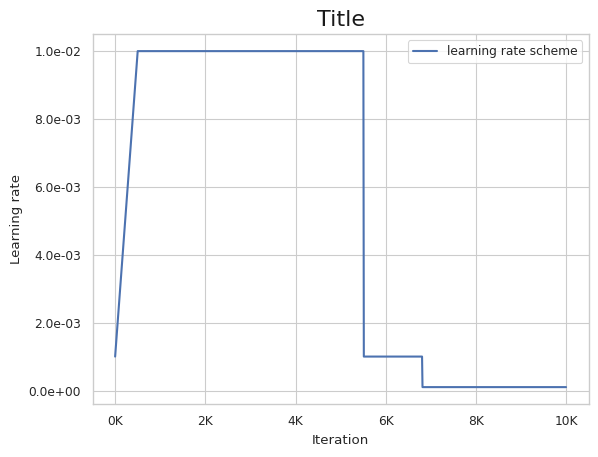

In [25]:
def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    """Multi-steps learning rate scheduler."""
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value)


def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    """Multi-steps warm up learning rate scheduler."""
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)


def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
        alpha=lr_min / initial_learning_rate)


class PiecewiseConstantWarmUpDecay(
        tf.keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule wiht warm up schedule.
    Modified from tf.keras.optimizers.schedules.PiecewiseConstantDecay"""

    def __init__(self, boundaries, values, warmup_steps, min_lr,
                 name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda v=v: tf.constant(v)))

            # The default isn't needed here because our conditions are mutually
            # exclusive and exhaustive, but tf.case requires it.
            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

    def get_config(self):
        return {
                "boundaries": self.boundaries,
                "values": self.values,
                "warmup_steps": self.warmup_steps,
                "min_lr": self.min_lr,
                "name": self.name
        }


if __name__ == "__main__":
    lr_scheduler = MultiStepWarmUpLR(1e-2, [5500, 6800], 0.1,
                                     warmup_steps=500, min_lr=1e-3)
    # lr_scheduler = MultiStepWarmUpLR(1e-3, [5500, 6800], 0.1)
    # lr_scheduler = MultiStepLR(1e-4, [500, 1000, 2000, 3000], 0.5)
    # lr_scheduler = CosineAnnealingLR_Restart(2e-4, 2500, 1e-7)

    ##############################
    # Draw figure
    ##############################
    N_iter = 10000
    step_list = list(range(0, N_iter, 10))
    lr_list = []
    for i in step_list:
        current_lr = lr_scheduler(i).numpy()
        lr_list.append(current_lr)

    import matplotlib as mpl
    from matplotlib import pyplot as plt
    import matplotlib.ticker as mtick
    mpl.style.use('default')
    import seaborn
    seaborn.set(style='whitegrid')
    seaborn.set_context('paper')

    plt.figure(1)
    plt.subplot(111)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.title('Title', fontsize=16, color='k')
    plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
    legend = plt.legend(loc='upper right', shadow=False)
    ax = plt.gca()
    labels = ax.get_xticks().tolist()
    for k, v in enumerate(labels):
        labels[k] = str(int(v / 1000)) + 'K'
    ax.set_xticklabels(labels)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

    ax.set_ylabel('Learning rate')
    ax.set_xlabel('Iteration')
    fig = plt.gcf()
    plt.show()

# modules - models.py

In [26]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU

## Original

In [27]:
def _regularizer(weights_decay):
    """l2 regularizer"""
    return tf.keras.regularizers.l2(weights_decay)


def _kernel_init(scale=1.0, seed=None):
    """He normal initializer"""
    return tf.keras.initializers.he_normal()


class BatchNormalization(tf.keras.layers.BatchNormalization):
    """Make trainable=False freeze BN for real (the og version is sad).
       ref: https://github.com/zzh8829/yolov3-tf2
    """
    def __init__(self, axis=-1, momentum=0.9, epsilon=1e-5, center=True,
                 scale=True, name=None, **kwargs):
        super(BatchNormalization, self).__init__(
            axis=axis, momentum=momentum, epsilon=epsilon, center=center,
            scale=scale, name=name, **kwargs)

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)

        return super().call(x, training)


def Backbone(backbone_type='ResNet50', use_pretrain=True):
    """Backbone Model"""
    weights = None
    if use_pretrain:
        weights = 'imagenet'

    def backbone(x):
        if backbone_type == 'ResNet50':
            extractor = ResNet50(
                input_shape=x.shape[1:], include_top=False, weights=weights)
            pick_layer1 = 80  # [80, 80, 512]
            pick_layer2 = 142  # [40, 40, 1024]
            pick_layer3 = 174  # [20, 20, 2048]
            preprocess = tf.keras.applications.resnet.preprocess_input
        elif backbone_type == 'MobileNetV2':
            extractor = MobileNetV2(
                input_shape=x.shape[1:], include_top=False, weights=weights)
            pick_layer1 = 54  # [80, 80, 32]
            pick_layer2 = 116  # [40, 40, 96]
            pick_layer3 = 143  # [20, 20, 160]
            preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
        else:
            raise NotImplementedError(
                'Backbone type {} is not recognized.'.format(backbone_type))

        return Model(extractor.input,
                     (extractor.layers[pick_layer1].output,
                      extractor.layers[pick_layer2].output,
                      extractor.layers[pick_layer3].output),
                     name=backbone_type + '_extrator')(preprocess(x))

    return backbone


class ConvUnit(tf.keras.layers.Layer):
    """Conv + BN + Act"""
    def __init__(self, f, k, s, wd, act=None, name='ConvBN', **kwargs):
        super(ConvUnit, self).__init__(name=name, **kwargs)
        self.conv = Conv2D(filters=f, kernel_size=k, strides=s, padding='same',
                           kernel_initializer=_kernel_init(),
                           kernel_regularizer=_regularizer(wd),
                           use_bias=False, name='conv')
        self.bn = BatchNormalization(name='bn')

        if act is None:
            self.act_fn = tf.identity
        elif act == 'relu':
            self.act_fn = ReLU()
        elif act == 'lrelu':
            self.act_fn = LeakyReLU(0.1)
        else:
            raise NotImplementedError(
                'Activation function type {} is not recognized.'.format(act))

    def call(self, x):
        return self.act_fn(self.bn(self.conv(x)))


class FPN(tf.keras.layers.Layer):
    """Feature Pyramid Network"""
    def __init__(self, out_ch, wd, name='FPN', **kwargs):
        super(FPN, self).__init__(name=name, **kwargs)
        act = 'relu'
        if (out_ch <= 64):
            act = 'lrelu'

        self.output1 = ConvUnit(f=out_ch, k=1, s=1, wd=wd, act=act)
        self.output2 = ConvUnit(f=out_ch, k=1, s=1, wd=wd, act=act)
        self.output3 = ConvUnit(f=out_ch, k=1, s=1, wd=wd, act=act)
        self.merge1 = ConvUnit(f=out_ch, k=3, s=1, wd=wd, act=act)
        self.merge2 = ConvUnit(f=out_ch, k=3, s=1, wd=wd, act=act)

    def call(self, x):
        output1 = self.output1(x[0])  # [80, 80, out_ch]
        output2 = self.output2(x[1])  # [40, 40, out_ch]
        output3 = self.output3(x[2])  # [20, 20, out_ch]

        up_h, up_w = tf.shape(output2)[1], tf.shape(output2)[2]
        up3 = tf.image.resize(output3, [up_h, up_w], method='nearest')
        output2 = output2 + up3
        output2 = self.merge2(output2)

        up_h, up_w = tf.shape(output1)[1], tf.shape(output1)[2]
        up2 = tf.image.resize(output2, [up_h, up_w], method='nearest')
        output1 = output1 + up2
        output1 = self.merge1(output1)

        return output1, output2, output3


class SSH(tf.keras.layers.Layer):
    """Single Stage Headless Layer"""
    def __init__(self, out_ch, wd, name='SSH', **kwargs):
        super(SSH, self).__init__(name=name, **kwargs)
        assert out_ch % 4 == 0
        act = 'relu'
        if (out_ch <= 64):
            act = 'lrelu'

        self.conv_3x3 = ConvUnit(f=out_ch // 2, k=3, s=1, wd=wd, act=None)

        self.conv_5x5_1 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=act)
        self.conv_5x5_2 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=None)

        self.conv_7x7_2 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=act)
        self.conv_7x7_3 = ConvUnit(f=out_ch // 4, k=3, s=1, wd=wd, act=None)

        self.relu = ReLU()

    def call(self, x):
        conv_3x3 = self.conv_3x3(x)

        conv_5x5_1 = self.conv_5x5_1(x)
        conv_5x5 = self.conv_5x5_2(conv_5x5_1)

        conv_7x7_2 = self.conv_7x7_2(conv_5x5_1)
        conv_7x7 = self.conv_7x7_3(conv_7x7_2)

        output = tf.concat([conv_3x3, conv_5x5, conv_7x7], axis=3)
        output = self.relu(output)

        return output


class BboxHead(tf.keras.layers.Layer):
    """Bbox Head Layer"""
    def __init__(self, num_anchor, wd, name='BboxHead', **kwargs):
        super(BboxHead, self).__init__(name=name, **kwargs)
        self.num_anchor = num_anchor
        self.conv = Conv2D(filters=num_anchor * 4, kernel_size=1, strides=1)

    def call(self, x):
        h, w = tf.shape(x)[1], tf.shape(x)[2]
        x = self.conv(x)

        return tf.reshape(x, [-1, h * w * self.num_anchor, 4])


class LandmarkHead(tf.keras.layers.Layer):
    """Landmark Head Layer"""
    def __init__(self, num_anchor, wd, name='LandmarkHead', **kwargs):
        super(LandmarkHead, self).__init__(name=name, **kwargs)
        self.num_anchor = num_anchor
        self.conv = Conv2D(filters=num_anchor * 10, kernel_size=1, strides=1)

    def call(self, x):
        h, w = tf.shape(x)[1], tf.shape(x)[2]
        x = self.conv(x)

        return tf.reshape(x, [-1, h * w * self.num_anchor, 10])


class ClassHead(tf.keras.layers.Layer):
    """Class Head Layer"""
    def __init__(self, num_anchor, wd, name='ClassHead', **kwargs):
        super(ClassHead, self).__init__(name=name, **kwargs)
        self.num_anchor = num_anchor
        self.conv = Conv2D(filters=num_anchor * 2, kernel_size=1, strides=1)

    def call(self, x):
        h, w = tf.shape(x)[1], tf.shape(x)[2]
        x = self.conv(x)

        return tf.reshape(x, [-1, h * w * self.num_anchor, 2])


def RetinaFaceModel(cfg, training=False, iou_th=0.4, score_th=0.02,
                    name='RetinaFaceModel'):
    """Retina Face Model"""
    input_size = cfg['input_size'] if training else None
    wd = cfg['weights_decay']
    out_ch = cfg['out_channel']
    num_anchor = len(cfg['min_sizes'][0])
    backbone_type = cfg['backbone_type']

    # define model
    x = inputs = Input([input_size, input_size, 3], name='input_image')

    x = Backbone(backbone_type=backbone_type)(x)

    fpn = FPN(out_ch=out_ch, wd=wd)(x)

    features = [SSH(out_ch=out_ch, wd=wd, name=f'SSH_{i}')(f)
                for i, f in enumerate(fpn)]

    bbox_regressions = tf.concat(
        [BboxHead(num_anchor, wd=wd, name=f'BboxHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)
    landm_regressions = tf.concat(
        [LandmarkHead(num_anchor, wd=wd, name=f'LandmarkHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)
    classifications = tf.concat(
        [ClassHead(num_anchor, wd=wd, name=f'ClassHead_{i}')(f)
         for i, f in enumerate(features)], axis=1)

    classifications = tf.keras.layers.Softmax(axis=-1)(classifications)

    if training:
        out = (bbox_regressions, landm_regressions, classifications)
    else:
        # only for batch size 1
        preds = tf.concat(  # [bboxes, landms, landms_valid, conf]
            [bbox_regressions[0], landm_regressions[0],
             tf.ones_like(classifications[0, :, 0][..., tf.newaxis]),
             classifications[0, :, 1][..., tf.newaxis]], 1)
        priors = prior_box_tf((tf.shape(inputs)[1], tf.shape(inputs)[2]),
                              cfg['min_sizes'],  cfg['steps'], cfg['clip'])
        decode_preds = decode_tf(preds, priors, cfg['variances'])

        selected_indices = tf.image.non_max_suppression(
            boxes=decode_preds[:, :4],
            scores=decode_preds[:, -1],
            max_output_size=tf.shape(decode_preds)[0],
            iou_threshold=iou_th,
            score_threshold=score_th)

        out = tf.gather(decode_preds, selected_indices)

    return Model(inputs, out, name=name)

# dataset Exporting to drive - only bbox and classifications

In [ ]:
# define prior box
priors = prior_box((cfg['input_size'], cfg['input_size']),
                    cfg['min_sizes'],  cfg['steps'], cfg['clip'])

priors

array([[0.00625, 0.00625, 0.025  , 0.025  ],
       [0.00625, 0.00625, 0.05   , 0.05   ],
       [0.01875, 0.00625, 0.025  , 0.025  ],
       ...,
       [0.925  , 0.975  , 0.8    , 0.8    ],
       [0.975  , 0.975  , 0.4    , 0.4    ],
       [0.975  , 0.975  , 0.8    , 0.8    ]])

In [ ]:
priors.shape

(16800, 4)

In [ ]:
# load dataset
train_dataset = load_dataset(cfg, priors, shuffle=True)

In [ ]:
from tqdm import tqdm
steps_per_epoch = cfg['dataset_len'] // cfg['batch_size']
steps_per_epoch

12880

In [ ]:
np.random.seed(1)

In [ ]:
for i,j in train_dataset.take(1):

    data = i[0].numpy()
    label = j[0].numpy()

    print(data.shape)
    print(label[:,[0,1,2,3,-2,-1]].shape)

    print()
    print(label[:,[0,1,2,3,-2,-1]])


(640, 640, 3)
(16800, 6)

[[ 3.1085504e+02  3.9293970e+02 -4.6967721e+00 -4.6967721e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.5542752e+02  1.9646985e+02 -8.1625080e+00 -8.1625080e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.0585504e+02  3.9293970e+02 -4.6967721e+00 -4.6967721e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-4.7322879e+00  3.7662681e-02 -1.8994764e+01 -1.8159508e+01
   0.0000000e+00  0.0000000e+00]
 [-1.6754894e+00  5.0284857e-01 -1.7788975e+01 -1.8559715e+01
   0.0000000e+00  0.0000000e+00]
 [-4.0136395e+00  1.5981196e-01 -1.8994780e+01 -1.8994780e+01
   0.0000000e+00  0.0000000e+00]]


In [ ]:
idx = 1
for i,j in tqdm(train_dataset.take(12880)):

    data = i[0].numpy()
    label = j[0].numpy()

    label = label[:,[0,1,2,3,-2,-1]]

    np.save(f'/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/{idx}.npy',
            data)
    np.save(f'/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/{idx}.npy',
            label)

    idx+=1


100%|██████████| 12880/12880 [22:33<00:00,  9.52it/s]


In [ ]:
len(os.listdir('/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels'))

12880

In [ ]:
len(dataset_list), len(label_list)

12880

In [ ]:
dataset_numpy = np.array(dataset_list)

# train.py

In [ ]:

# flags.DEFINE_string('cfg_path', './configs/retinaface_res50.yaml',
#                 'config file path')
# flags.DEFINE_string('gpu', '0', 'which gpu to use')

In [28]:
# init
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu

logger = tf.get_logger()
logger.disabled = True
logger.setLevel(logging.FATAL)
set_memory_growth()

#cfg = load_yaml(FLAGS.cfg_path)

# define network
model = RetinaFaceModel(cfg, training=True)
model.summary(line_length=80)

# define prior box
priors = prior_box((cfg['input_size'], cfg['input_size']),
                    cfg['min_sizes'],  cfg['steps'], cfg['clip'])

# load dataset
train_dataset = load_dataset(cfg, priors, shuffle=True)

9420800/9406464 [==============================] - 0s 0us/step
Model: "RetinaFaceModel"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_image (InputLayer)  [(None, 640, 640  0       []                         
                          , 3)]                                                 
                                                                                
 tf.math.truediv (TFOpLam  (None, 640, 640,  0       ['input_image[0][0]']      
 bda)                      3)                                                   
                                                                                
 tf.math.subtract (TFOpLa  (None, 640, 640,  0       ['tf.math.truediv[0][0]']  
 mbda)                     3)                                                   
                                                                                
 MobileNetV2_extrator

In [31]:
for i, j in train_dataset.take(1):

  xtemp = i
  ytemp = j

In [32]:
xtemp.shape, ytemp.shape

(TensorShape([1, 640, 640, 3]), TensorShape([1, 16800, 16]))

In [38]:
ypred_temp1 = model(xtemp)
ypred_temp1

(<tf.Tensor: shape=(1, 16800, 4), dtype=float32, numpy=
 array([[[ 0.35473648,  0.13475156,  3.7759504 ,  6.856581  ],
         [-1.531177  ,  0.48871338, -2.081355  , -0.12608624],
         [ 3.5543811 , -4.8035517 ,  6.689021  ,  7.8595057 ],
         ...,
         [-3.0992239 ,  1.319152  ,  2.2535667 ,  1.4098037 ],
         [-0.70297134, -3.591864  ,  0.22981703, -0.15286635],
         [-2.8850117 ,  3.7312758 ,  2.0049443 ,  0.9901669 ]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 16800, 10), dtype=float32, numpy=
 array([[[-1.3899478 , -4.0483303 , -3.9506795 , ..., -0.06935198,
          -1.0926036 , -0.50610954],
         [ 1.4040815 , -0.27496356,  1.8950644 , ..., -0.70333517,
           2.2094898 , -1.42324   ],
         [ 1.691037  , -4.472405  , -1.4335517 , ..., -1.655506  ,
          -3.3709562 ,  4.684601  ],
         ...,
         [ 0.31487387, -0.2155874 , -3.7514577 , ..., -1.291543  ,
           2.559754  , -0.7800139 ],
         [ 0.78551584,  1.4627323 ,  2.5

In [39]:
type(ypred_temp1)

tuple

In [40]:
ypred_temp = list(ypred_temp1)
len(ypred_temp)

3

In [41]:
ypred_temp[0].shape, ypred_temp[1].shape, ypred_temp[2].shape

(TensorShape([1, 16800, 4]),
 TensorShape([1, 16800, 10]),
 TensorShape([1, 16800, 2]))

In [43]:
# define losses function
multi_box_loss = MultiBoxLoss()

multi_box_loss(ytemp, ypred_temp)

(<tf.Tensor: shape=(), dtype=float32, numpy=4.817335>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.3045397>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.088662>)

In [ ]:
# define optimizer
steps_per_epoch = cfg['dataset_len'] // cfg['batch_size']
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=cfg['init_lr'],
    lr_steps=[e * steps_per_epoch for e in cfg['lr_decay_epoch']],
    lr_rate=cfg['lr_rate'],
    warmup_steps=cfg['warmup_epoch'] * steps_per_epoch,
    min_lr=cfg['min_lr'])
optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate, momentum=0.9, nesterov=True)


# load checkpoint
checkpoint_dir = './checkpoints/' + cfg['sub_name']
checkpoint = tf.train.Checkpoint(step=tf.Variable(0, name='step'),
                                    optimizer=optimizer,
                                    model=model)
manager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                        directory=checkpoint_dir,
                                        max_to_keep=3)
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print('[*] load ckpt from {} at step {}.'.format(
        manager.latest_checkpoint, checkpoint.step.numpy()))
else:
    print("[*] training from scratch.")

In [ ]:




# define losses function
multi_box_loss = MultiBoxLoss()



# define training step function
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)

        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)
        losses['loc'], losses['landm'], losses['class'] = \
            multi_box_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

# training loop
summary_writer = tf.summary.create_file_writer('./logs/' + cfg['sub_name'])
remain_steps = max(
    steps_per_epoch * cfg['epoch'] - checkpoint.step.numpy(), 0)
prog_bar = ProgressBar(steps_per_epoch,
                        checkpoint.step.numpy() % steps_per_epoch)

for inputs, labels in train_dataset.take(remain_steps):
    checkpoint.step.assign_add(1)
    steps = checkpoint.step.numpy()

    total_loss, losses = train_step(inputs, labels)

    prog_bar.update("epoch={}/{}, loss={:.4f}, lr={:.1e}".format(
        ((steps - 1) // steps_per_epoch) + 1, cfg['epoch'],
        total_loss.numpy(), optimizer.lr(steps).numpy()))

    if steps % 10 == 0:
        with summary_writer.as_default():
            tf.summary.scalar(
                'loss/total_loss', total_loss, step=steps)
            for k, l in losses.items():
                tf.summary.scalar('loss/{}'.format(k), l, step=steps)
            tf.summary.scalar(
                'learning_rate', optimizer.lr(steps), step=steps)

    if steps % cfg['save_steps'] == 0:
        manager.save()
        print("\n[*] save ckpt file at {}".format(
            manager.latest_checkpoint))

manager.save()
print("\n[*] training done! save ckpt file at {}".format(
    manager.latest_checkpoint))



Model: "RetinaFaceModel"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_image (InputLayer)  [(None, None, No  0       []                         
                          ne, 3)]                                               
                                                                                
 tf.compat.v1.shape (TFOp  (4,)             0        ['input_image[0][0]']      
 Lambda)                                                                        
                                                                                
 tf.compat.v1.shape_1 (TF  (4,)             0        ['input_image[0][0]']      
 OpLambda)                                                                      
                                                                                
 tf.__operators__.getitem  ()               0        ['tf.compat.v1.shape[0][0]'
 _6

ValueError: ignored

## test widerface.py

In [ ]:
# flags.DEFINE_string('cfg_path', './configs/retinaface_res50.yaml',
#                     'config file path')
# flags.DEFINE_string('gpu', '0', 'which gpu to use')
# flags.DEFINE_string('save_folder', './widerface_evaluate/widerface_txt/',
#                     'folder path to save evaluate results')
# flags.DEFINE_boolean('origin_size', True,
#                      'whether use origin image size to evaluate')
# flags.DEFINE_boolean('save_image', True, 'whether save evaluation images')
# flags.DEFINE_float('iou_th', 0.4, 'iou threshold for nms')
# flags.DEFINE_float('score_th', 0.02, 'score threshold for nms')
# flags.DEFINE_float('vis_th', 0.5, 'threshold for visualization')

In [ ]:
!mkdirwiderface_evaluate

In [ ]:
save_folder = '/content/widerface_evaluate'
origin_size = True
save_image = True
iou_th = .4
score_th = .02
vis_th = .5

In [ ]:
import pathlib

def load_info(txt_path):
    """load info from txt"""
    img_paths = []
    words = []

    f = open(txt_path, 'r')
    lines = f.readlines()
    isFirst = True
    labels = []
    for line in lines:
        line = line.rstrip()
        if line.startswith('#'):
            if isFirst is True:
                isFirst = False
            else:
                labels_copy = labels.copy()
                words.append(labels_copy)
                labels.clear()
            path = line[2:]
            path = txt_path.replace('label.txt', 'images/') + path
            img_paths.append(path)
        else:
            line = line.split(' ')
            label = [float(x) for x in line]
            labels.append(label)

    words.append(labels)
    return img_paths, words




logger = tf.get_logger()
logger.disabled = True
logger.setLevel(logging.FATAL)
set_memory_growth()

#cfg = load_yaml(cfg_path)

# define network
model = RetinaFaceModel(cfg, training=False, iou_th=iou_th,
                        score_th=score_th)

# load checkpoint
checkpoint_dir = './checkpoints/' + cfg['sub_name']
checkpoint = tf.train.Checkpoint(model=model)
if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("[*] load ckpt from {}.".format(
        tf.train.latest_checkpoint(checkpoint_dir)))
else:
    print("[*] Cannot find ckpt from {}.".format(checkpoint_dir))
    exit()

# evaluation on testing dataset
testset_folder = cfg['testing_dataset_path']
testset_list = os.path.join(testset_folder, 'label.txt')

img_paths, _ = load_info(testset_list)
for img_index, img_path in enumerate(img_paths):
    print(" [{} / {}] det {}".format(img_index + 1, len(img_paths),
                                        img_path))
    img_raw = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_height_raw, img_width_raw, _ = img_raw.shape
    img = np.float32(img_raw.copy())

    # testing scale
    target_size = 1600
    max_size = 2150
    img_shape = img.shape
    img_size_min = np.min(img_shape[0:2])
    img_size_max = np.max(img_shape[0:2])
    resize = float(target_size) / float(img_size_min)
    
    # prevent bigger axis from being more than max_size:
    if np.round(resize * img_size_max) > max_size:
        resize = float(max_size) / float(img_size_max)
    if origin_size:
        if os.path.basename(img_path) == '6_Funeral_Funeral_6_618.jpg':
            resize = 0.5 # this image is too big to avoid OOM problem
        else:
            resize = 1

    img = cv2.resize(img, None, None, fx=resize, fy=resize,
                        interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # pad input image to avoid unmatched shape problem
    img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))

    # run model
    outputs = model(img[np.newaxis, ...]).numpy()

    # recover padding effect
    outputs = recover_pad_output(outputs, pad_params)

    # write results
    img_name = os.path.basename(img_path)
    sub_dir = os.path.basename(os.path.dirname(img_path))
    save_name = os.path.join(
        save_folder, sub_dir, img_name.replace('.jpg', '.txt'))

    pathlib.Path(os.path.join(save_folder, sub_dir)).mkdir(
        parents=True, exist_ok=True)

    with open(save_name, "w") as file:
        bboxs = outputs[:, :4]
        confs = outputs[:, -1]

        file_name = img_name + "\n"
        bboxs_num = str(len(bboxs)) + "\n"
        file.write(file_name)
        file.write(bboxs_num)
        for box, conf in zip(bboxs, confs):
            x = int(box[0] * img_width_raw)
            y = int(box[1] * img_height_raw)
            w = int(box[2] * img_width_raw) - int(box[0] * img_width_raw)
            h = int(box[3] * img_height_raw) - int(box[1] * img_height_raw)
            confidence = str(conf)
            line = str(x) + " " + str(y) + " " + str(w) + " " + str(h) \
                + " " + confidence + " \n"
            file.write(line)

    # save images
    pathlib.Path(os.path.join(
        './results', cfg['sub_name'], sub_dir)).mkdir(
            parents=True, exist_ok=True)
    if save_image:
        for prior_index in range(len(outputs)):
            if outputs[prior_index][15] >= vis_th:
                draw_bbox_landm(img_raw, outputs[prior_index],
                                img_height_raw, img_width_raw)
        cv2.imwrite(os.path.join('./results', cfg['sub_name'], sub_dir,
                                    img_name), img_raw)

## test.py

In [ ]:


# flags.DEFINE_string('cfg_path', './configs/retinaface_res50.yaml',
#                     'config file path')
# flags.DEFINE_string('gpu', '0', 'which gpu to use')
# flags.DEFINE_string('img_path', '', 'path to input image')
# flags.DEFINE_boolean('webcam', False, 'get image source from webcam or not')
# flags.DEFINE_float('iou_th', 0.4, 'iou threshold for nms')
# flags.DEFINE_float('score_th', 0.5, 'score threshold for nms')
# flags.DEFINE_float('down_scale_factor', 1.0, 'down-scale factor for inputs')



In [ ]:
img_path = 
iou_th = 0.4
score_th = 0.5
down_scale_factor = 1.0

In [ ]:

logger = tf.get_logger()
logger.disabled = True
logger.setLevel(logging.FATAL)
set_memory_growth()

cfg = load_yaml(FLAGS.cfg_path)

# define network
model = RetinaFaceModel(cfg, training=False, iou_th=FLAGS.iou_th,
                        score_th=FLAGS.score_th)

# load checkpoint
checkpoint_dir = './checkpoints/' + cfg['sub_name']
checkpoint = tf.train.Checkpoint(model=model)
if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("[*] load ckpt from {}.".format(
        tf.train.latest_checkpoint(checkpoint_dir)))
else:
    print("[*] Cannot find ckpt from {}.".format(checkpoint_dir))
    exit()

if not FLAGS.webcam:
    if not os.path.exists(FLAGS.img_path):
        print(f"cannot find image path from {FLAGS.img_path}")
        exit()

    print("[*] Processing on single image {}".format(FLAGS.img_path))

    img_raw = cv2.imread(FLAGS.img_path)
    img_height_raw, img_width_raw, _ = img_raw.shape
    img = np.float32(img_raw.copy())

    if FLAGS.down_scale_factor < 1.0:
        img = cv2.resize(img, (0, 0), fx=FLAGS.down_scale_factor,
                            fy=FLAGS.down_scale_factor,
                            interpolation=cv2.INTER_LINEAR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # pad input image to avoid unmatched shape problem
    img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))

    # run model
    outputs = model(img[np.newaxis, ...]).numpy()

    # recover padding effect
    outputs = recover_pad_output(outputs, pad_params)

    # draw and save results
    save_img_path = os.path.join('out_' + os.path.basename(FLAGS.img_path))
    for prior_index in range(len(outputs)):
        draw_bbox_landm(img_raw, outputs[prior_index], img_height_raw,
                        img_width_raw)
        cv2.imwrite(save_img_path, img_raw)
    print(f"[*] save result at {save_img_path}")

else:
    cam = cv2.VideoCapture(0)

    start_time = time.time()
    while True:
        _, frame = cam.read()
        if frame is None:
            print("no cam input")

        frame_height, frame_width, _ = frame.shape
        img = np.float32(frame.copy())
        if FLAGS.down_scale_factor < 1.0:
            img = cv2.resize(img, (0, 0), fx=FLAGS.down_scale_factor,
                                fy=FLAGS.down_scale_factor,
                                interpolation=cv2.INTER_LINEAR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # pad input image to avoid unmatched shape problem
        img, pad_params = pad_input_image(img, max_steps=max(cfg['steps']))

        # run model
        outputs = model(img[np.newaxis, ...]).numpy()

        # recover padding effect
        outputs = recover_pad_output(outputs, pad_params)

        # draw results
        for prior_index in range(len(outputs)):
            draw_bbox_landm(frame, outputs[prior_index], frame_height,
                            frame_width)

        # calculate fps
        fps_str = "FPS: %.2f" % (1 / (time.time() - start_time))
        start_time = time.time()
        cv2.putText(frame, fps_str, (25, 25),
                    cv2.FONT_HERSHEY_DUPLEX, 0.75, (0, 255, 0), 2)

        # show frame
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == ord('q'):
            exit()


# Modified model

In [ ]:
input_size = (640,640,3)

In [ ]:
base_model = MobileNetV2(input_shape = input_size, include_top=False, weights= 'imagenet')

base_model.trainable = False



In [ ]:
base_model.summary()

In [ ]:
base_model.layers[143].output

<KerasTensor: shape=(None, 20, 20, 960) dtype=float32 (created by layer 'block_16_expand')>

In [ ]:
base_model.input

<KerasTensor: shape=(None, 640, 640, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
pick_layer1 = 54  # [80, 80, 192]
pick_layer2 = 116  # [40, 40, 576]
pick_layer3 = 143  # [20, 20, 960]

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# define model
inputs = Input(input_size, name='input_image')

x = preprocess_input(inputs)
mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)
mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)
mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)

model = Model(inputs,
              (mobilenetv2_layer1_80,
               mobilenetv2_layer2_40,
               mobilenetv2_layer3_20))

model.summary()

In [ ]:
1518464 + 613952 + 65152 

2197568

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


#model.save_weights('model.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# load json and create model
with open('model.json', 'r') as json_file:
    model_json = json_file.read()

model = tf.keras.models.model_from_json(model_json)
# load weights into new model
#model.load_weights("model.h5")

In [ ]:
model.summary()

In [ ]:
def conv_block(prev_layer, name, filters, kernel, stride, act = True):
    x =  Conv2D(filters = filters, 
                kernel_size = kernel, 
                strides = stride, 
                padding='same',
                kernel_initializer = tf.keras.initializers.he_normal(),
                use_bias = False,
                name = name+'conv')(prev_layer)
    
    x = BatchNormalization(epsilon=1e-5,
                           name = name+'batchnorm')(x)

    if act:
        x = ReLU(name = name+'relu')(x)
               
    
    return x

In [ ]:
def fpn(input_layer1, input_layer2, input_layer3):
    output1 = conv_block(input_layer1,
                        'fpn1_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 80, 80, 64)
    
    output2 = conv_block(input_layer2,
                        'fpn2_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 40, 40, 64)
    
    output3 = conv_block(input_layer3,
                        'fpn3_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 20, 20, 64)
    
    #Up sampling + feature fusion
    up_h2, up_w2 = tf.shape(output2)[1], tf.shape(output2)[2]         #up_h = 40, up_w = 40
    up3 = tf.image.resize(output3, [up_h2, up_w2], method='nearest')   # (None,40,40,64)
    output2 = output2 + up3                                                         # (None,40,40,64)


    merge2 = conv_block(output2,
                        'fpn2_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                                  # (None,40,40,64)
    

    #Up sampling + feature fusion
    up_h1, up_w1 = tf.shape(output1)[1], tf.shape(output1)[2]         #up_h = 80, up_w = 80
    up2 = tf.image.resize(merge2, [up_h1, up_w1], method='nearest')   # (None,80,80,64)
    output1 = output1 + up2                                                  # (None,80,80,64)


    merge1 = conv_block(output1,
                        'fpn1_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                               # (None,80,80,64)

                        
    return merge1, merge2, output3

In [ ]:
o1,o2,o3 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)

print(o1)
print(o2)
print(o3)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 64), dtype=tf.float32, name=None), name='fpn1_merge_relu/Relu:0', description="created by layer 'fpn1_merge_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 64), dtype=tf.float32, name=None), name='fpn2_merge_relu/Relu:0', description="created by layer 'fpn2_merge_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 64), dtype=tf.float32, name=None), name='fpn3_relu/Relu:0', description="created by layer 'fpn3_relu'")


In [ ]:
def ssh(prev_layer, name):
    conv_3x3 = conv_block(prev_layer,
                        name = name + 'conv_3x3',
                        filters = 64//2,
                        kernel = 3,
                        stride = 1,
                         act = False)      

    conv_5x5_1 = conv_block(prev_layer,
                        name = name + 'conv_5x5_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_5x5 = conv_block(conv_5x5_1,
                        name = name + 'conv_5x5',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)  

    conv_7x7_1 = conv_block(conv_5x5_1,
                        name = name + 'conv_7x7_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_7x7 = conv_block(conv_7x7_1,
                        name = name + 'conv_7x7',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)    

    output = tf.concat([conv_3x3, conv_5x5, conv_7x7], axis=3)
    output = keras.layers.ReLU(name = name+'final_relu')(output)   

    return output

In [ ]:
ssh2 = ssh(o2, 'ssh2_40_')

In [ ]:
ssh2

<KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'ssh2_40_final_relu')>

In [ ]:
min_sizes = [[16, 32], [64, 128], [256, 512]]
len(min_sizes)

3

In [ ]:
def classification_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 2, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 2])


def bbox_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 4, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 4])

In [ ]:
# define model
inputs = Input(input_size, name='input_image')

x = preprocess_input(inputs)
mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)      #(None, 80, 80, 192)
mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)      #(None, 40, 40, 576)
mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)      #(None, 20, 20, 960)

#feature pyramid network
fpn_layer1_80, fpn_layer2_40, fpn_layer3_20 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)

ssh_layer1 = ssh(fpn_layer1_80, name = 'ssh1_80_')
ssh_layer2 = ssh(fpn_layer2_40, name = 'ssh2_40_')
ssh_layer3 = ssh(fpn_layer3_20, name = 'ssh3_20_')

#Classification head
classification_layer1 = classification_head(ssh_layer1, len(min_sizes[0]), 'classification_layer1')
classification_layer2 = classification_head(ssh_layer2, len(min_sizes[0]), 'classification_layer2')
classification_layer3 = classification_head(ssh_layer3, len(min_sizes[0]), 'classification_layer3')

classifications = tf.concat([classification_layer1,
                             classification_layer2,
                             classification_layer3], axis=1)

#classification activation function 
classifications = tf.keras.layers.Softmax(axis = -1, name = 'classifications_softmax')(classifications)


#bounding box regressions head
bbox_layer1 = bbox_head(ssh_layer1, len(min_sizes[0]), 'bbox_layer1')
bbox_layer2 = bbox_head(ssh_layer2, len(min_sizes[0]), 'bbox_layer2')
bbox_layer3 = bbox_head(ssh_layer3, len(min_sizes[0]), 'bbox_layer3')

bbox_regressions = tf.concat([bbox_layer1,
                              bbox_layer2,
                              bbox_layer3], axis=1)

#output
output = (bbox_regressions, classifications)

model = Model(inputs, output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_3 (TFOpLambda)  (None, 640, 640, 3)  0          ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 640, 640, 3)  0          ['tf.math.truediv_3[0][0]']      
 )                                                                                                
                                                                                            

In [ ]:
tf.keras.utils.plot_model(model, 
                          to_file='/content/drive/MyDrive/AI_Notebooks_and_Models/RetinaFace/Original/model_original.png', 
                          show_shapes=True,
                          show_layer_names=True)

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/AI_Notebooks_and_Models/RetinaFace/Original/model_original.json", "w") as json_file:
    json_file.write(model_json)


model.save_weights('/content/drive/MyDrive/AI_Notebooks_and_Models/RetinaFace/Original/model_original_withoutTraining.h5')


In [ ]:

preds = tf.concat(  # [bboxes,  landms_valid, conf]
    [bbox_regressions[0],
    tf.ones_like(classifications[0, :, 0][..., tf.newaxis]),
    classifications[0, :, 1][..., tf.newaxis]], 1)

priors = prior_box_tf((tf.shape(inputs)[1], tf.shape(inputs)[2]),
                        cfg['min_sizes'],  cfg['steps'], cfg['clip'])

decode_preds = decode_tf(preds, priors, cfg['variances'])

selected_indices = tf.image.non_max_suppression(
    boxes=decode_preds[:, :4],
    scores=decode_preds[:, -1],
    max_output_size=tf.shape(decode_preds)[0],
    iou_threshold=iou_th,
    score_threshold=score_th)

out = tf.gather(decode_preds, selected_indices)

In [ ]:
cfg

{'backbone_type': 'MobileNetV2',
 'batch_size': 4,
 'clip': False,
 'dataset_len': 12880,
 'dataset_path': '/content/widerface_train_bin.tfrecord',
 'epoch': 1,
 'ignore_thresh': 0.3,
 'init_lr': 0.01,
 'input_size': 640,
 'lr_decay_epoch': [50, 68],
 'lr_rate': 0.1,
 'match_thresh': 0.45,
 'min_lr': 0.001,
 'min_sizes': [[16, 32], [64, 128], [256, 512]],
 'momentum': 0.9,
 'out_channel': 64,
 'pretrain': True,
 'save_steps': 1000,
 'steps': [8, 16, 32],
 'sub_name': 'retinaface_mbv2',
 'using_bin': True,
 'using_distort': True,
 'using_flip': True,
 'variances': [0.1, 0.2],
 'warmup_epoch': 5,
 'weights_decay': 0.0005}

In [ ]:
len(cfg['min_sizes'][0])

2

# Model defining and training - train.py

# END